# GANs
In this project, we will first implement the original GAN and the Wasserstein GAN (WGAN) on a toy problem to see how the relatively small changes can lead to big changes during training. Then, we will train a Conditional GAN (cGAN) on MNIST.

## Setup
```
conda env create -f environments/environment-gpu.yml
conda activate vae
```

or

```
conda env create -f environments/environment-cpu-only.yml
conda activate vae
```

---

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from utils import init_params, print_params, clamp_params, plot_inline

torch.manual_seed(1337)
np.random.seed(1337)


## Part 1: Original GAN vs WGAN

In this part of the assignment, we will implement a simple GAN to learn the distribution of a 2D toy-dataset. You will implement the trainig loop and the targets for the critic and the generator, **both according to the original GAN paper and the WGAN paper**. Here, we want you to see that WGANs are more stable and produce better results. 

### Dataset
The dataset is a simple Gaussian mixture with 4 components located at (-1, -1), (-1, 1), (1, 1), and (1, -1). The code below will load the dataset and plot it.

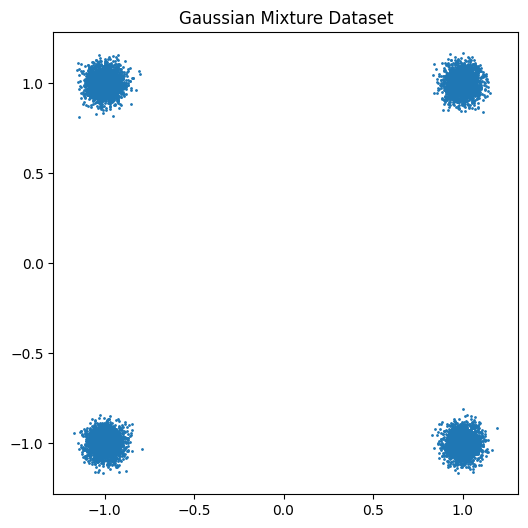

In [2]:
class GaussianMixtureDataset(Dataset):
    def __init__(self):
        self.probs = [0.25, 0.25, 0.25, 0.25]
        self.sigmas_x = [0.05, 0.05, 0.05, 0.05]
        self.sigmas_y = [0.05, 0.05, 0.05, 0.05]
        self.means_x = [-1, 1, 1, -1]
        self.means_y = [-1, -1, 1, 1]

        self.examples: np.ndarray = self.make_examples()  # Nx2 array

    def __len__(self) -> int:
        return self.examples.shape[0]

    def __getitem__(self, idx: np.ndarray) -> np.ndarray:
        return self.examples[idx, :]

    # Return one sample from a 2D gaussian mixture model
    def get_gmm_sample(
        self,
        probs: List[float],
        means_x: List[float],
        means_y: List[float],
        sigmas_x: List[float],
        sigmas_y: List[float],
    ) -> Tuple[float, float]:
        nof_gaussians: int = len(means_x)
        gaussian_no: int = np.random.choice(np.arange(nof_gaussians), p=probs)
        value_x: float = np.random.normal(means_x[gaussian_no], sigmas_x[gaussian_no])
        value_y: float = np.random.normal(means_y[gaussian_no], sigmas_y[gaussian_no])
        return (value_x, value_y)

    # Create all examples
    def make_examples(self) -> np.ndarray:
        n_examples: int = 10_000
        examples: np.ndarray = np.zeros((n_examples, 2), np.float32)
        for ix in range(n_examples):
            (x, y) = self.get_gmm_sample(
                self.probs, self.means_x, self.means_y, self.sigmas_x, self.sigmas_y
            )
            examples[ix, 0] = x
            examples[ix, 1] = y

        return examples


dataset = GaussianMixtureDataset()
dataset.make_examples()
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(dataset.examples[:, 0], dataset.examples[:, 1], s=1)
plt.title("Gaussian Mixture Dataset")
plt.show()


### Generator and Critic
Here, we want to implement the generator and the critic. Both should be simple MLPs. 

The generator should be an MLP with one input layer, one hidden layer with 128 units, and one output layer with two units and no activation. The other layers should have a LeakyReLU activation.

The critic should be an MLP with one input layer, one hidden layer with 8 units, and one output layer with 2 units and no activation. The other layers should have a LeakyReLU activation.

*If you want to use a different architecture, you can do so, but you will have to tune the hyperparameters yourself.*

In [3]:
# Generator model, generating examples from noise
class Generator(nn.Module):
    def __init__(self, latent_space_dims: int):
        super(Generator, self).__init__()
        self.latent_space_dims = latent_space_dims
        # Define the generator network.
        # The input is an NxL tensor with N examples drawn from an
        # L-dimensional drawn normal distribution. The output should be an Nx2
        # tensor containing N generated examples.
        self.net = nn.Sequential(
            nn.Linear(latent_space_dims, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)


class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        # Define the critic network.
        # The input is an Nx2 tensor with N examples. The output should be
        # classification results (logits) arranged as an Nx2 tensor.
        self.net = nn.Sequential(
            nn.Linear(2, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [4]:
lat_dim = 42
generator_input = torch.randn(10, lat_dim)
generator = Generator(latent_space_dims=lat_dim)
assert generator(generator_input).shape == (10, 2), "Generator output shape is wrong"

critic_input = torch.randn(10, 2)
critic = Critic()
assert critic(critic_input).shape == (10, 2), "Critic output shape is wrong"


### Targets
Here, we want you to implement the GAN target for the generator and the critic. We want to implement the original GAN target and the WGAN target, **however**, we want you to start with only implementing the `original` targets and then continue to training the networks. Once that is done, you can come back here and implement the `wgan` targets.

In [8]:
class GeneratorTarget(nn.Module):
    def __init__(self, gan_type: str):
        if gan_type not in ("original", "wgan"):
            raise ValueError("GAN type should be either 'original' or 'wgan'.")
        self.gan_type = gan_type
        super(GeneratorTarget, self).__init__()

    def forward(self, critic_output_fake: torch.Tensor):
        """Compute the target for the generator.

        Args:
            critic_output_fake: Output of the critic for the fake examples. Batch size x 2.

        """
        if self.gan_type == "original":
            # Using non-saturating loss
            target = torch.mean(torch.log(critic_output_fake))

        elif self.gan_type == "wgan":
            target = torch.mean(critic_output_fake)
            

        else:
            raise ValueError("GAN type should be either 'original' or 'wgan'.")

        return target


In [5]:
class CriticTarget(nn.Module):
    def __init__(self, gan_type):
        if gan_type not in ("original", "wgan"):
            raise ValueError("Mode should be either 'original' or 'wgan'.")
        self.gan_type = gan_type
        super(CriticTarget, self).__init__()

    def forward(
        self, critic_output_real: torch.Tensor, critic_output_fake: torch.Tensor
    ):
        """Compute the target for the critic.

        Args:
            critic_output_real: Output of the critic for real examples.
            critic_output_fake: Output of the critic for fake examples.
        Returns:
            Target for the critic.
        """
        if self.gan_type == "original":
            target = torch.mean(torch.log(critic_output_real)) + torch.mean(torch.log(1-critic_output_fake))

        elif self.gan_type == "wgan":
            target = torch.mean(critic_output_real) + torch.mean(1-critic_output_fake)

        else:
            raise ValueError("GAN type should be either 'original' or 'wgan'.")

        return target


### Trainer
Here, we want you to implement the training of the GAN. Most of the code is written but you should complete the `train_generator`, and the `train_critic` methods.


In [9]:
class GanTrainer:
    def __init__(
        self,
        mode: str,
        latent_size: int,
        learning_rate: float,
        n_generator_steps: int,
        n_critics_steps: int,
        batch_size: int,
        training_steps: int,
        device: str,
    ):
        assert mode in (
            "original",
            "wgan",
        ), "Mode should be either 'original' or 'wgan'."

        self.mode = mode
        self.device = device
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.n_critics_steps = n_critics_steps
        self.n_generator_steps = n_generator_steps
        self.lr = learning_rate
        self.training_steps = training_steps

        # Setup data
        self.dataset = GaussianMixtureDataset()
        self.data_loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

        # Setup models
        self.generator = Generator(latent_size)
        self.critic = Critic()
        self.critic.apply(init_params)

        # Setup optimization targets
        self.generator_target = GeneratorTarget(self.mode)
        self.critic_target = CriticTarget(self.mode)

        # Setup optimizers, note that these only optimize the parameters of their respective models
        self.critic_optim = torch.optim.RMSprop(
            self.critic.parameters(), maximize=True, lr=self.lr
        )
        self.generator_optim = torch.optim.RMSprop(
            self.generator.parameters(), maximize=True, lr=self.lr
        )

        # Move everything to the right device (CPU or GPU)
        self.generator.to(self.device)
        self.critic.to(self.device)
        self.generator_target.to(self.device)
        self.critic_target.to(self.device)

    # Run main training loop
    def train(self):
        critic_targets = []
        generator_targets = []
        for step in range(self.training_steps):
            # Train critic and generator for a few steps each
            critic_target = self.train_critic()
            generator_target = self.train_generator()

            # Show progress
            if step % 1000 == 0:
                # print_params(self.critic)  # Enable for debugging
                generator_targets.append(generator_target)
                critic_targets.append(critic_target)
                # plot the generated samples
                noise = self.make_noise_input(512)
                examples = self.generator(noise)
                examples = examples.detach().cpu().numpy()
                plot_inline(
                    examples,
                    generator_targets,
                    critic_targets,
                    step,
                    self.dataset.means_x,
                    self.dataset.means_y,
                )
                print(
                    f"step: {step}, critic target (max): {critic_target}, generator target (min): {generator_target}"
                )

        return self.generator, critic_targets, generator_targets

    # Generate an NxL tensor of noise inputs to the generator
    # (N is sample size, L is latent space dimensionality)
    def make_noise_input(self, sample_size: int):
        return torch.randn(sample_size, self.latent_size).to(self.device)

    # Run a few steps of critic training
    def train_critic(self):
        """Train the critic for a few steps."""
        for _ in range(self.n_critics_steps):
            real_data = next(iter(self.data_loader)).to(self.device)
            # YOUR CODE HERE
            critic_output_real = self.critic(real_data)

            z = torch.randn(self.batch_size, self.latent_size).to(self.device)
            g_z = self.generator(z)
            critic_output_fake = self.critic(g_z)

            loss = self.critic_target(critic_output_real, critic_output_fake)

            self.critic_optim.zero_grad()
            loss.backward()
            self.critic_optim.step()

            if self.mode == "wgan":
                with torch.no_grad():
                    self.critic.apply(clamp_params)

        # Return the last loss we observed
        return loss.item()

    # Run a few steps of generator training
    def train_generator(self):
        """Train the generator for a few steps."""
        for _ in range(self.n_generator_steps):
            # YOUR CODE HERE
            z = torch.randn(self.batch_size, self.latent_size).to(self.device)
            g_z = self.generator(z)
            critic_output = self.critic(g_z)
            loss = self.generator_target(critic_output)

            # note that the generator optimizer only has access to the generators' parameters
            # thus we don't need to zero the critic parameters
            self.generator_optim.zero_grad()
            loss.backward()
            self.generator_optim.step()

        # Return the last loss we observed
        return loss.item()


First, implement the original GAN loss for the critic and the generator, and train the GAN by having `GAN_TYPE = "original"`. With the parameter settings below, you should see that the training results in mode collapse. After that, implement the WGAN loss for the critic and the generator, and train the GAN by having `GAN_TYPE = "wgan"`. With the parameter settings below, you should see that the training results in a much more stable training process and produces better results.

We can also play around with the parameters and see if you can stabilize the training of the original GAN. You can also try to improve the results of the WGAN by changing the parameters.

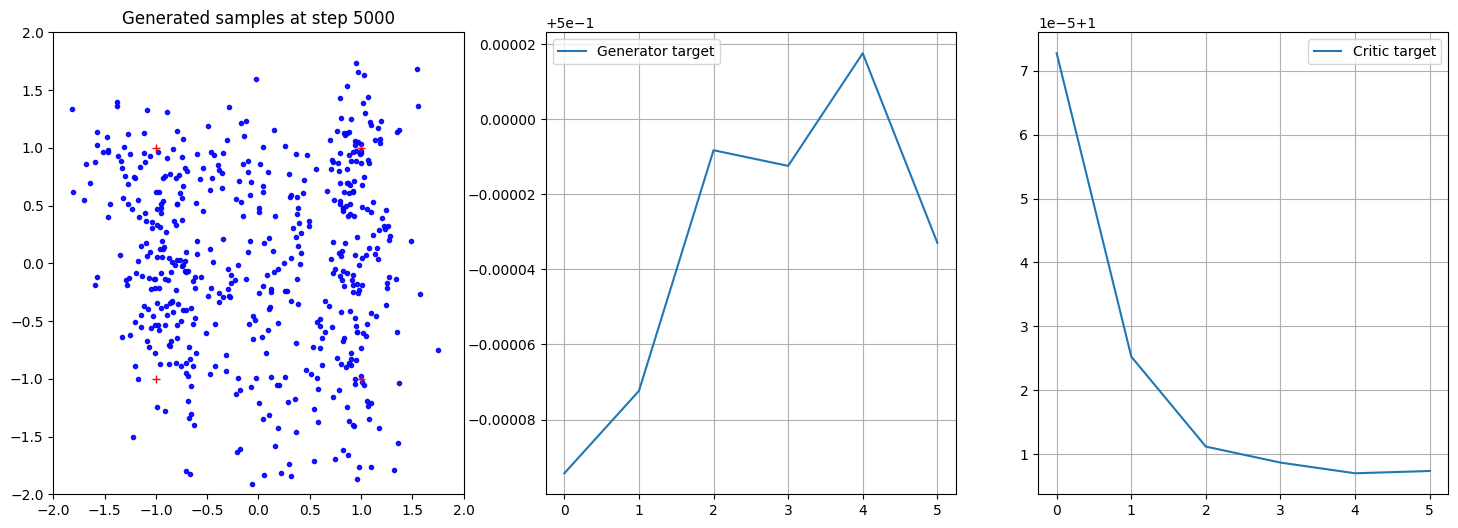

step: 5000, critic target (max): 1.0000073909759521, generator target (min): 0.4999670684337616


In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
# Training details, default:
# 10_000 steps, 256 batch size, 32 latent space dimensions, 1 generator step, 5 critic steps, 0.0005 learning rate
BATCH_SIZE = 256
LATENT_SPACE_DIMS = 32
GENERATOR_TRAINING_STEPS = 1
CRITIC_TRAINING_STEPS = 5
LEARNING_RATE = 0.0005
TRAINING_STEPS = 30_000
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# WGAN specifics
PARAM_CLAMP = 0.01

# original or wgan
GAN_TYPE = "wgan"

trainer = GanTrainer(
    mode=GAN_TYPE,
    latent_size=LATENT_SPACE_DIMS,
    learning_rate=LEARNING_RATE,
    n_generator_steps=GENERATOR_TRAINING_STEPS,
    n_critics_steps=CRITIC_TRAINING_STEPS,
    batch_size=BATCH_SIZE,
    training_steps=TRAINING_STEPS,
    device=DEVICE,
)

generator, critic_targets, generator_targets = trainer.train()

Let's plot the target curves, along with some generated examples

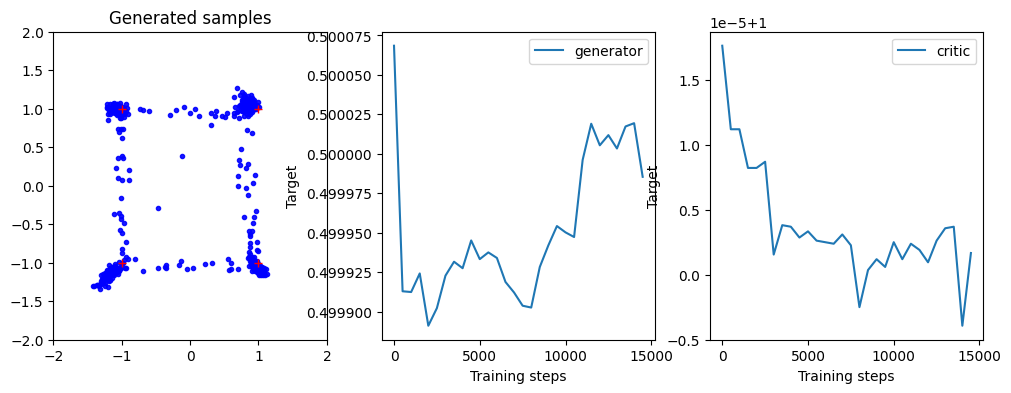

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

noise = trainer.make_noise_input(512)
examples = generator(noise)
examples = examples.detach().cpu().numpy()
ax[0].plot(examples[:, 0], examples[:, 1], "b.", alpha=0.9)
ax[0].plot(trainer.dataset.means_x, trainer.dataset.means_y, "r+")
ax[0].set_title("Generated samples")
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)

# plot generator and critic targets, every 500 steps
x = np.arange(0, len(critic_targets)) * 500
ax[1].plot(x, generator_targets, label="generator")
ax[1].legend()
ax[1].set_xlabel("Training steps")
ax[1].set_ylabel("Target")

ax[2].plot(x, critic_targets, label="critic")
ax[2].legend()
ax[2].set_xlabel("Training steps")
ax[2].set_ylabel("Target")
plt.savefig(f"{OUTPUT_DIR}/{GAN_TYPE}_training.png")
plt.show()

In the generated data it is possible that you will see only some of the modes represented, what is commonly called mode collapse. 

- What are commonly cited reasons for mode collapse?
- How does WGAN attempt to avoid mode collapse?

Mode collapse is a phenomena that is often observed with GANs when the generator generates a subset of the true data distribution that we want to sample from. It typically occurrs because in certain regions the classifier struggle more with separating the samples from the true data and the generator learns to exploit this.

WGAN attempts to solve this by solving the issue of when comparing two probability distributions in regions where one of the distributions has zero density. It does so by introducing the Earth Mover Distance (EMD). In the WGAN paper they say that mode collapse comes from the optimal generator for a fixed discriminator is a sum of deltas on the points that the discriminator assigns the highest values of being a real sample. And argue that using the EMD during training makes it impossible to collapse modes since they can now train the critic until optimality.

It could potentially be interesting to see how the decision boundary looks. Note that the output is bounded (0,1) when using `GAN_TYPE="original"`, which is not the case for `GAN_TYPE="wgan"` and therefore we normalize the outputs to this range in the latter case.

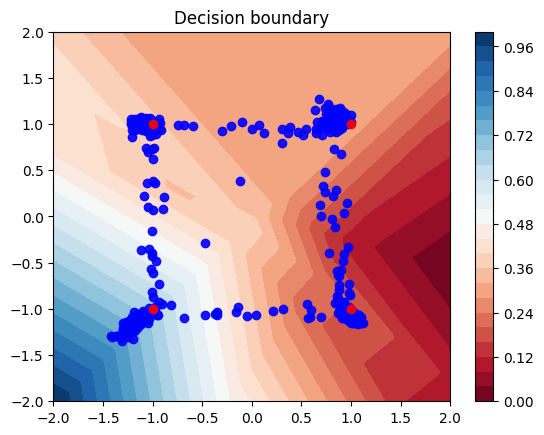

In [88]:
# plot the decision boundary of the discriminator
x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.tensor(grid, dtype=torch.float32).to(DEVICE)
trainer.critic.eval()
with torch.no_grad():
    if GAN_TYPE == "wgan":
        probs = trainer.critic(grid)[:, 0]
        # note that the critic output is not bounded as in the original GAN, so we normalize it to [0, 1]
        # to be able to plot it.
        probs = (probs - probs.min()) / (probs.max() - probs.min())
    elif GAN_TYPE == "original":
        probs = trainer.critic(grid)
        probs = torch.softmax(probs, dim=1)[:, 0]
probs = probs.cpu().numpy().reshape(xx.shape)
# normalize to [0, 1]

# countour plot
plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
plt.colorbar()
# scatter plot
plt.scatter(examples[:, 0], examples[:, 1], c="b", alpha=0.9)
plt.scatter(trainer.dataset.means_x, trainer.dataset.means_y, c="r", alpha=0.9)
plt.title("Decision boundary")
plt.savefig(f"{OUTPUT_DIR}/decision_boundary_{GAN_TYPE}.png")
plt.show()




Now, you've seen that changing from the original GAN to the WGAN can make a big difference. Especially, the WGAN is more stable and, in general, produces better results. As you've seen, there are only minor differences between the two implementations. One difference is that we clamp the parameters of the critic `self.critic.apply(clamp_params)` when using the WGAN. 

Why do we do this?
What would happen if we didn't do this?

The function in the Wasserstein metric needs to be K-Lipschitz continuous. This constraint can be challenging. Clamping the weights to a small winsow results in a compact parameter space and is a practical way that the authors argue gives K-Lipschitz continuity. If we would not do this, the Wasserstein metric would not work, i.e the loss trying to pull p_generator towards p_data would possibly not work. I don't find any proofs to why this is the case, but this what the research suggests. 